# Evaluation of potentially inhibible reactions

In [1]:
# Import packages

import pandas as pd
from cobra import Model, Reaction, Metabolite
from cobra.io import read_sbml_model
import os
import numpy as np
import re
from collections import Counter

In [2]:
# Load refined model
ros = read_sbml_model("/home/jorgexd/ROS/ros_model.xml")
ros.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ca2_e,EX_ca2_e,0.002594,0,0.00%
cl_e,EX_cl_e,0.002594,0,0.00%
cobalt2_e,EX_cobalt2_e,0.001866,0,0.00%
cu2_e,EX_cu2_e,0.001729,0,0.00%
fe2_e,EX_fe2_e,0.009015,0,0.00%
glc__D_e,EX_glc__D_e,6.3,6,99.99%
k_e,EX_k_e,0.0973,0,0.00%
mg2_e,EX_mg2_e,0.004324,0,0.00%
mn2_e,EX_mn2_e,0.001729,0,0.00%
mobd_e,EX_mobd_e,0.002003,0,0.00%


In [3]:
# Load full dataset
ros_table = pd.read_csv("/home/jorgexd/ROS/ROS_summary_BRENDA_full.tsv", sep = '\t', encoding='latin1')
ros_table.head()

,KEGG ID,UniProt ID,Gene,Protein,# SR in AS,Mean SR - AS minimum distance,cys in AS,# SR in BS,Mean SR - BS minimum distance,cys in BS,# Disulfide bonds,Mean S-S - AS/BS minimum distance,Cofactor,Subsystem,Evidence,Study organism,ecNumber,EC class,BRENDA evidence,BRENDA organism
0,PP_0243,Q88R90,gshA,Glutamate--cysteine ligase,0,0.00,0,0,0.00,0,0,0.0,NaN,S_Glutamate_Metabolism,Reduction of disulfide bonds lead to the inact...,Arabidopsis Thaliana,6.3.2.2,Ligases,NaN,NaN
1,PP_0808,Q88PP0,hmp,Flavohemoprotein,1,4.51,0,8,5.11,0,0,0.0,heme b (C34H30FeN4O4),S_Nitrogen_Metabolism,BRENDA,Bovine,1.14.12.17,Oxidoreductases,NaN,NaN
2,PP_5228,Q88CF3,dapF,Diaminopimelate epimerase,2,6.14,2,4,4.72,0,0,0.0,NaN,S_Lysine_Metabolism,When CgDapF was treated with various concentra...,Corynebacterium glutamicum,5.1.1.7,Isomerases,NaN,NaN
3,PP_0915,Q88PD5,sodB,Superoxide dismutase [Fe],0,0.00,0,3,4.23,0,0,0.0,Fe cation (Fe),Unassigned,Gradual inactivation of the enzyme due to ROS ...,E.coli,1.15.1.1,Oxidoreductases,"An, S.S.; Kim, Y.M.: Purification and charact...",Stemona tuberosa AND Marinomonas sp. AND Homo ...
4,PP_0415,Q88QS3,rpe,Ribulose-phosphate 3-epimerase,0,5.13,0,2,5.95,0,0,0.0,Co(2+) (Co) AND Fe(2+) (Fe) AND Mn(2+) (Mn) AN...,S_Pentose_Phosphate_Pathway,"Easily affected by ROS, although this effect c...",E.coli,5.1.3.1,Isomerases,NaN,NaN


In [4]:
# Load susceptible dataset 
evidenced_table = pd.read_csv('/home/jorgexd/ROS/Pputida_evidenced.txt', sep = '\t', encoding = 'latin1')
evidenced_table.head()

,KEGG ID,UniProt ID,Gene,Protein,# SR in AS,Mean SR - AS minimum distance,cys in AS,# SR in BS,Mean SR - BS minimum distance,cys in BS,# Disulfide bonds,Mean S-S - AS/BS minimum distance,Cofactor,Subsystem,Evidence,Study organism,ecNumber,EC class,BRENDA evidence,BRENDA organism
0,PP_0732,Q88PW6,hemA,Glutamyl-tRNA reductase,1,3.83,1,6,4.85,1,0,0.0,NaN,S_Cofactor_and_Prosthetic_Group_Biosynthesis__...,BRENDA,NaN,1.2.1.70,Oxidoreductases,suggesting that cysteine residues are the prim...,Acidithiobacillus ferrooxidans
1,PP_4715,Q88DV4,tpiA,Triosephosphate isomerase,1,4.37,0,1,5.10,0,0,0.0,NaN,S_Gluconeogenesis,BRENDA,NaN,5.3.1.1,Isomerases,oxidation of cystein residues,Arabidopsis thaliana AND Chlamydomonas reinhar...
2,PP_3668,Q88GQ0,katG,Catalase-peroxidase,1,3.86,0,2,5.24,0,0,0.0,heme b (C34H30FeN4O4),Unassigned,BRENDA,NaN,1.11.1.21,Oxidoreductases,"Steinman, H.M.; Fareed, F.; Weinstein, L.: Ca...",Archaeoglobus fulgidus AND Rhodobacter capsula...
3,PP_1001,Q88P52,arcA,Arginine deiminase,1,3.87,1,0,0.00,0,0,0.0,NaN,S_Arginine_and_Proline_Metabolism,BRENDA,NaN,3.5.3.6,Hydrolases,oxidation of cystein residues,Aspergillus nidulans
4,PP_0398,Q88QT9,glpE,Thiosulfate sulfurtransferase GlpE,1,3.85,1,0,0.00,0,0,0.0,NaN,S_Sulfur_Metabolism,BRENDA,NaN,2.8.1.1,Transferases,"In the absence of reduced thioredoxin, the sul...",Bos taurus


In [5]:
# Combine datasets to build susceptible dataset
# Proteins with cysteins in AS or BS and FeS clusters, heme groups or Fe2+ as cofactors will be considered
ros_table_sset = ros_table[(ros_table["cys in AS"] > 0) | (ros_table["cys in BS"] > 0) |
                           (ros_table["Cofactor"].str.contains(r"\d+Fe-\d+S", regex=True, na=False)) |
                           (ros_table["Cofactor"].str.contains(r"Fe\(2\+\)", na=False)) |
                           (ros_table["Cofactor"].str.contains(r"heme", na=False)) ]

susceptible_table = pd.concat([ros_table_sset, evidenced_table], ignore_index=True).drop_duplicates()
print(susceptible_table.shape)
susceptible_table.head()


(156, 20)


,KEGG ID,UniProt ID,Gene,Protein,# SR in AS,Mean SR - AS minimum distance,cys in AS,# SR in BS,Mean SR - BS minimum distance,cys in BS,# Disulfide bonds,Mean S-S - AS/BS minimum distance,Cofactor,Subsystem,Evidence,Study organism,ecNumber,EC class,BRENDA evidence,BRENDA organism
0,PP_0808,Q88PP0,hmp,Flavohemoprotein,1,4.51,0,8,5.11,0,0,0.0,heme b (C34H30FeN4O4),S_Nitrogen_Metabolism,BRENDA,Bovine,1.14.12.17,Oxidoreductases,NaN,NaN
1,PP_5228,Q88CF3,dapF,Diaminopimelate epimerase,2,6.14,2,4,4.72,0,0,0.0,NaN,S_Lysine_Metabolism,When CgDapF was treated with various concentra...,Corynebacterium glutamicum,5.1.1.7,Isomerases,NaN,NaN
2,PP_0415,Q88QS3,rpe,Ribulose-phosphate 3-epimerase,0,5.13,0,2,5.95,0,0,0.0,Co(2+) (Co) AND Fe(2+) (Fe) AND Mn(2+) (Mn) AN...,S_Pentose_Phosphate_Pathway,"Easily affected by ROS, although this effect c...",E.coli,5.1.3.1,Isomerases,NaN,NaN
3,PP_2112,Q88L24,acnA-I,Aconitate hydratase,0,0.00,0,0,0.00,0,0,0.0,[4Fe-4S] cluster (Fe4S4),S_TCA_Cycle,"Upon ROS exposure, mitoNEET [2Fe-2S] cluster ...","E.coli, Human",4.2.1.3,Lyases,NaN,Rattus rattus AND Rattus norvegicus
4,PP_2336,Q88KF4,acnA-II,aconitate hydratase,0,0.00,0,0,0.00,0,0,0.0,[4Fe-4S] cluster (Fe4S4),S_Alternate_Carbon__Propanoate_Metabolism,Aconitase is sensitive to superoxide; see Gard...,"E.coli, Human",4.2.1.3,Lyases,NaN,Rattus rattus AND Rattus norvegicus


In [6]:
susceptible_enz = susceptible_table["KEGG ID"].tolist()

In [7]:
susceptible_table.to_csv("All_susceptible.txt", sep = '\t', index = False)

In [8]:
# Get only those reactions having all its enzymes affected
to_knock = []
pattern = r'PP_\d{4}'

reactions_gpr = {}
for rxn in ros.reactions:
    matches = re.findall(pattern, str(rxn.gpr))
    if matches:
        reactions_gpr[rxn.id] = matches

for reaction, gprs in reactions_gpr.items():
    if set(gprs).issubset(set(susceptible_enz)):
        to_knock.append(reaction)
        print(f'\nReaction {reaction} is inhibited by ROS')
        print(ros.reactions.get_by_id(reaction))


Reaction 34HPPOR is inhibited by ROS
34HPPOR: 34hpp_c + o2_c --> co2_c + hgentis_c

Reaction ACONTb is inhibited by ROS
ACONTb: acon_C_c + h2o_c <=> icit_c

Reaction AMAOTr is inhibited by ROS
AMAOTr: 8aonn_c + amet_c <=> amob_c + dann_c

Reaction APRAUR is inhibited by ROS
APRAUR: 5apru_c + h_c + nadph_c --> 5aprbu_c + nadp_c

Reaction ARGDr is inhibited by ROS
ARGDr: arg__L_c + h2o_c --> citr__L_c + nh4_c

Reaction ASAD is inhibited by ROS
ASAD: aspsa_c + nadp_c + pi_c <=> 4pasp_c + h_c + nadph_c

Reaction ASNS1 is inhibited by ROS
ASNS1: asp__L_c + atp_c + gln__L_c + h2o_c --> amp_c + asn__L_c + glu__L_c + h_c + ppi_c

Reaction ASP3H is inhibited by ROS
ASP3H: akg_c + asp__L_c + o2_c --> 3hasp__L_c + co2_c + succ_c

Reaction CARBSARAH is inhibited by ROS
CARBSARAH: Ncarbsar_c + h2o_c + 2.0 h_c --> co2_c + nh4_c + sarcs_c

Reaction CAT is inhibited by ROS
CAT: 2.0 h2o2_c --> 2.0 h2o_c + o2_c

Reaction CATDOX is inhibited by ROS
CATDOX: catechol_c + o2_c --> ccmuac_c + 2.0 h_c

React

In [9]:
# Knockout individual genes directly
from cobra.flux_analysis import single_gene_deletion

deletions = single_gene_deletion(ros, susceptible_enz)
print(deletions)

           ids        growth   status
0    {PP_0823}  6.138368e-01  optimal
1    {PP_4282}  6.138368e-01  optimal
2    {PP_5128} -1.229138e-15  optimal
3    {PP_2659}  6.138368e-01  optimal
4    {PP_0777}  6.138368e-01  optimal
..         ...           ...      ...
138  {PP_1916}  6.138368e-01  optimal
139  {PP_0438} -3.181674e-12  optimal
140  {PP_2008}  6.138368e-01  optimal
141  {PP_3166}  6.138368e-01  optimal
142  {PP_3633}  6.138368e-01  optimal

[143 rows x 3 columns]


In [10]:
import matplotlib.pyplot as plt

def plot_knockouts(deletions, model, color = 'skyblue', figsize=(20,5)):
    "Plots bar plot with the objective value after carrying out specific deletions"
    obj_value = model.summary()._objective_value

    ids = deletions["ids"].tolist()
    formatted_ids = []
    for i in ids:
        string = str(i)
        formatted_ids.append(string.replace('{', '').replace('}', '').replace('\'', ''))

    growth = deletions["growth"].tolist()

    plt.figure(figsize=figsize)  
    plt.bar(formatted_ids, growth, color=color)  
    plt.axhline(y=obj_value, color='red', linestyle='--', linewidth=0.5, label=f'Wild-type growth ({obj_value:.2f})')
    plt.xlabel('Genes')  
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Growth')    
    plt.title('Individual knockout of reactions') 
    plt.tight_layout()
    plt.show()
    

def get_knockouts(deletions, model, effect='deletereous'):
    """Retrieves genes that are deletereous or problematic (reduce objective value) when knocked out"""

    if effect == 'deletereous':
        essential_rxns = deletions[deletions["growth"] < 0.00001]

    elif effect == 'problematic':
        obj_value = model.summary()._objective_value
        essential_rxns = deletions[(deletions["growth"] < obj_value - 0.01 ) & (deletions["growth"] > 0.00001)]

    else:
        print(f'Error: invalid effect {effect}')
        return []
        
    essential_rxns_ids = essential_rxns["ids"]
    essentials = []

    for eri in essential_rxns_ids:
        string = str(eri)
        essentials.append(string.replace('{', '').replace('}', '').replace('\'', ''))

    for es in essentials:
        gene = ros.genes.get_by_id(es)
        reactions = gene.reactions
        print(gene)
        for rxn in reactions:
            print(rxn)
        print('')

    return essentials


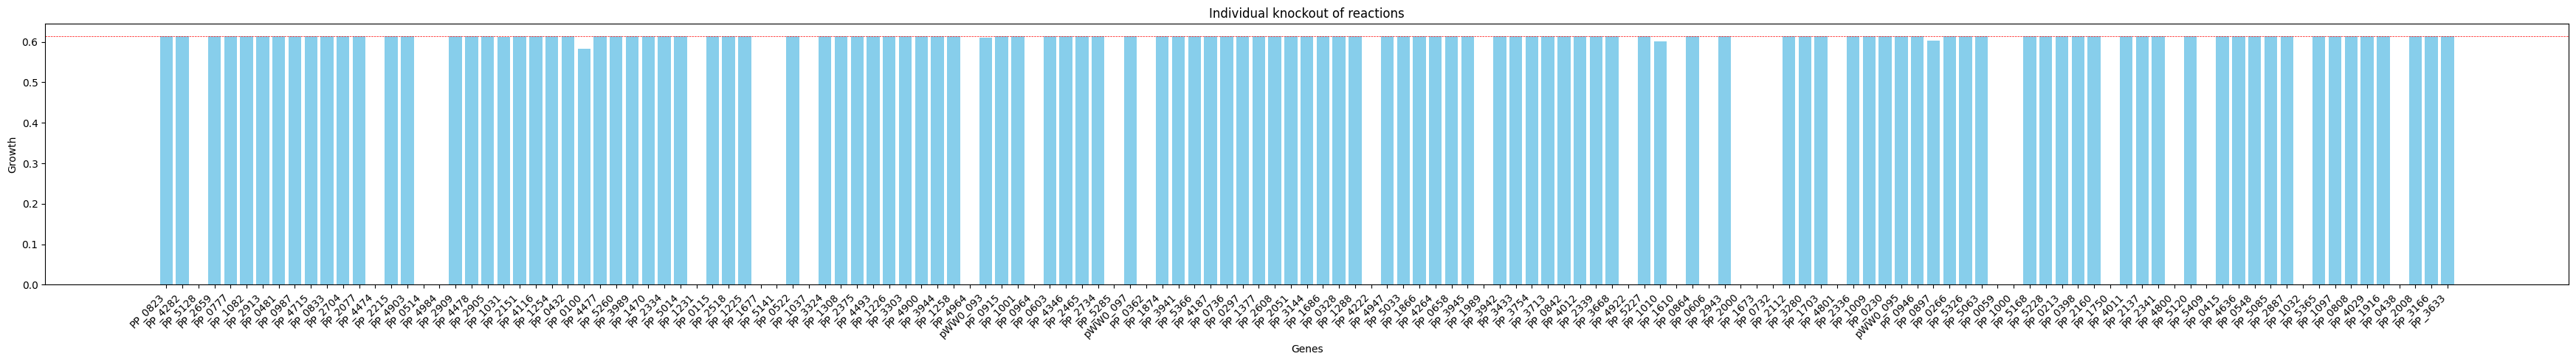

In [11]:
# Plot knockouts
plot_knockouts(deletions, ros, figsize=(35,5))

In [12]:
# Get deletereous reactions
deletereous = get_knockouts(deletions, ros, 'deletereous')

PP_5128
DHAD1_ROS: 23dhmb_c + 0.005 h_c + 0.005 nadh_c + 0.005 o2_c --> 3mob_c + 0.005 h2o2_c + h2o_c + 0.005 nad_c
DHAD2_ROS: 23dhmp_c + 0.005 nadh_c + 0.005 o2_c --> 3mop_c + 0.005 h2o2_c + 0.99 h2o_c + 0.015 h_c + 0.005 nad_c + 0.005 o2s_c

PP_4474
ALATRS: ala__L_c + atp_c + trnaala_c --> alatrna_c + amp_c + ppi_c

PP_0514
DHPPDA2: 25drapp_c + h2o_c + h_c --> 5apru_c + nh4_c
APRAUR: 5apru_c + h_c + nadph_c --> 5aprbu_c + nadp_c

PP_4984
AMAOTr: 8aonn_c + amet_c <=> amob_c + dann_c

PP_1231
QULNS_ROS: dhap_c + iasp_c + 1.005 nadh_c + 0.005 o2_c --> 0.005 h2o2_c + 2.0 h2o_c + 1.015 h_c + 1.005 nad_c + pi_c + quln_c

PP_1677
ADCYRS: adcobdam_c + 4.0 atp_c + 4.0 gln__L_c + 4.0 h2o_c --> adcobhex_c + 4.0 adp_c + 4.0 glu__L_c + 4.0 h_c + 4.0 pi_c

PP_5141
TMDS: dump_c + mlthf_c --> dhf_c + dtmp_c

PP_1037
PRFGS: atp_c + fgam_c + gln__L_c + h2o_c --> adp_c + fpram_c + glu__L_c + h_c + pi_c

PP_4964
E4PD: e4p_c + h2o_c + nad_c <=> 4per_c + 2.0 h_c + nadh_c

PP_0964
UAGCVT: pep_c + uacgam_c 

In [13]:
print('The following susceptible proteins are critical for organism survival:')
for gene in deletereous:
    genename = susceptible_table.loc[susceptible_table["KEGG ID"] == gene, "Protein"].iloc[0]
    subsystem = susceptible_table.loc[susceptible_table["KEGG ID"] == gene, "Subsystem"].iloc[0]
    print(f'{gene} : {genename} ({subsystem})')

The following susceptible proteins are critical for organism survival:
PP_5128 : Dihydroxy-acid dehydratase (S_Valine__Leucine__and_Isoleucine_Metabolism)
PP_4474 : Alanine--tRNA ligase (S_tRNA_Charging)
PP_0514 : Riboflavin biosynthesis protein RibD (S_Cofactor_and_Prosthetic_Group_Biosynthesis__Riboflavin_Metabolism)
PP_4984 : Adenosylmethionine-8-amino-7-oxononanoate aminotransferase (S_Cofactor_and_Prosthetic_Group_Biosynthesis__Biotin_Biosynthesis)
PP_1231 : Quinolinate synthase (S_Cofactor_and_Prosthetic_Group_Biosynthesis__Nicotinamide_Biosynthesis)
PP_1677 : Cobyric acid synthase (S_Cofactor_and_Prosthetic_Group_Biosynthesis__Porphyrin_and_Chlorophyll_Metabolism)
PP_5141 : Thymidylate synthase (S_Pyrimidine_Metabolism)
PP_1037 : Phosphoribosylformylglycinamidine synthase (S_Purine_Metabolism)
PP_4964 : Erythrose-4-phosphate dehydrogenase (S_Cofactor_and_Prosthetic_Group_Biosynthesis__Vitamin_B6_Metabolism)
PP_0964 : UDP-N-acetylglucosamine 1-carboxyvinyltransferase (S_Cell_Enve

In [14]:
# Get problematic reactions
problematic = get_knockouts(deletions, ros, 'problematic')

PP_0100
HCO3E: co2_c + h2o_c <=> h_c + hco3_c
H2CO3D: co2_c + h2o_c <=> h2co3_c

PP_1010
EDD: 6pgc_c --> 2ddg6p_c + h2o_c

PP_0897
FUM_ROS_F: fum_c + h2o_c + 0.005 h_c + 0.005 nadh_c + 0.005 o2_c --> 0.004545 h2o2_c + mal__L_c + 0.005 nad_c + 0.0004545 o2s_c
FUM_ROS_R: 0.004 h_c + mal__L_c + 0.005 nadh_c + 0.005 o2_c --> fum_c + 0.004545 h2o2_c + h2o_c + 0.005 nad_c + 0.0004545 o2s_c



In [15]:
print('The following susceptible proteins have an impact on the organism survival:')
for gene in problematic:
    genename = susceptible_table.loc[susceptible_table["KEGG ID"] == gene, "Protein"].iloc[0]
    subsystem = susceptible_table.loc[susceptible_table["KEGG ID"] == gene, "Subsystem"].iloc[0]
    print(f'{gene} : {genename} ({subsystem})')

The following susceptible proteins have an impact on the organism survival:
PP_0100 : Carbonic anhydrase (Unassigned)
PP_1010 : Phosphogluconate dehydratase (S_Glycolysis)
PP_0897 : Fumarate hydratase class I (S_TCA_Cycle)


### Subsystem evaluation and grouping

In [16]:
def extract_subsystems(ros_table, ident):
    subsystems = []
    subsystem = ros_table.loc[ros_table["KEGG ID"] == ident, "Subsystem"].iloc[0]
    all_subsystems = subsystem.split(' AND ')
    
    for ss in all_subsystems:
        refined_subsystem = ss.split('__')[0].replace('S_', '').replace('_',' ')
        subsystems.append(refined_subsystem)

    return subsystems

In [17]:
# Cant access subsystem directly from reactions
# Use the evidence table
subsystems = []

for rxn_name, gpr in reactions_gpr.items():
    if rxn_name in to_knock:
        rxn_subsystems = []
        for ID in gpr:
            ss = extract_subsystems(ros_table, ID)
            rxn_subsystems.extend(ss)
        
        rxn_subsystems = list(set(rxn_subsystems))
        subsystems.extend(rxn_subsystems)

print(subsystems)

['Aromatic Compounds Degradation', 'TCA Cycle', 'Cofactor and Prosthetic Group Biosynthesis', 'Cofactor and Prosthetic Group Biosynthesis', 'Arginine and Proline Metabolism', 'Lysine Metabolism', 'Alanine and Aspartate Metabolism', 'Iron uptake and metabolism', 'Aromatic Compounds Degradation', 'Alternate Carbon and Nitrogen source', 'Unassigned', 'Aromatic Compounds Degradation', 'Unassigned', 'Cofactor and Prosthetic Group Biosynthesis', 'Unassigned', 'Cofactor and Prosthetic Group Biosynthesis', 'Fatty Acid', 'Fatty Acid', 'Fatty Acid', 'Fatty Acid', 'Pyrimidine Metabolism', 'tRNA Charging', 'Methionine Metabolism', 'Cysteine Metabolism', 'Cofactor and Prosthetic Group Biosynthesis', 'Glycolysis', 'Formaldehyde Metabolism', 'Aromatic Compounds Degradation', 'Alginate biosynthesis', 'Cell Envelope Biosynthesis', 'Purine Metabolism', 'Glutamate Metabolism', 'Cofactor and Prosthetic Group Biosynthesis', 'Alternate Carbon and Nitrogen source', 'Butanoate Metabolism', 'Histidine Metaboli

In [18]:
# Count occurrences of each subsystem in susceptible reactions
        
subs_count = Counter(subsystems)
print(subs_count)

Counter({'Fatty Acid Metabolism': 35, 'Cofactor and Prosthetic Group Biosynthesis': 29, 'Valine': 28, 'Aromatic Compounds Degradation': 10, 'TCA Cycle': 10, 'Arginine and Proline Metabolism': 9, 'Unassigned': 9, 'Alternate Carbon and Nitrogen source': 8, 'Lysine Metabolism': 5, 'tRNA Charging': 5, 'Glutamate Metabolism': 5, 'Butanoate Metabolism': 5, 'Fatty Acid': 4, 'Methionine Metabolism': 4, 'Cell Envelope Biosynthesis': 4, 'Purine Metabolism': 4, 'Pyrimidine Metabolism': 3, 'Cysteine Metabolism': 3, 'Histidine Metabolism': 3, 'Biomass and maintenance functions': 3, 'Nucleotide Salvage Pathway': 3, 'Nitrogen Metabolism': 3, 'Glycine': 3, 'Transport': 2, 'Alternate Carbon': 2, 'Alanine and Aspartate Metabolism': 1, 'Iron uptake and metabolism': 1, 'Glycolysis': 1, 'Formaldehyde Metabolism': 1, 'Alginate biosynthesis': 1, 'Pentose Phosphate Pathway': 1, 'Gluconeogenesis': 1, 'Urea cycleamino group metabolism': 1})


In [19]:
# Enriched in peripheral metabolism
peri_enriched = ['Alternate Carbon and Nitrogen Source', 'Fatty Acids Metabolism', 'Aromatic Compounds Degradation', \
 'Alternate Carbon Source', 'Xenobiotic Tolerance', 'Nitrogen Metabolism']

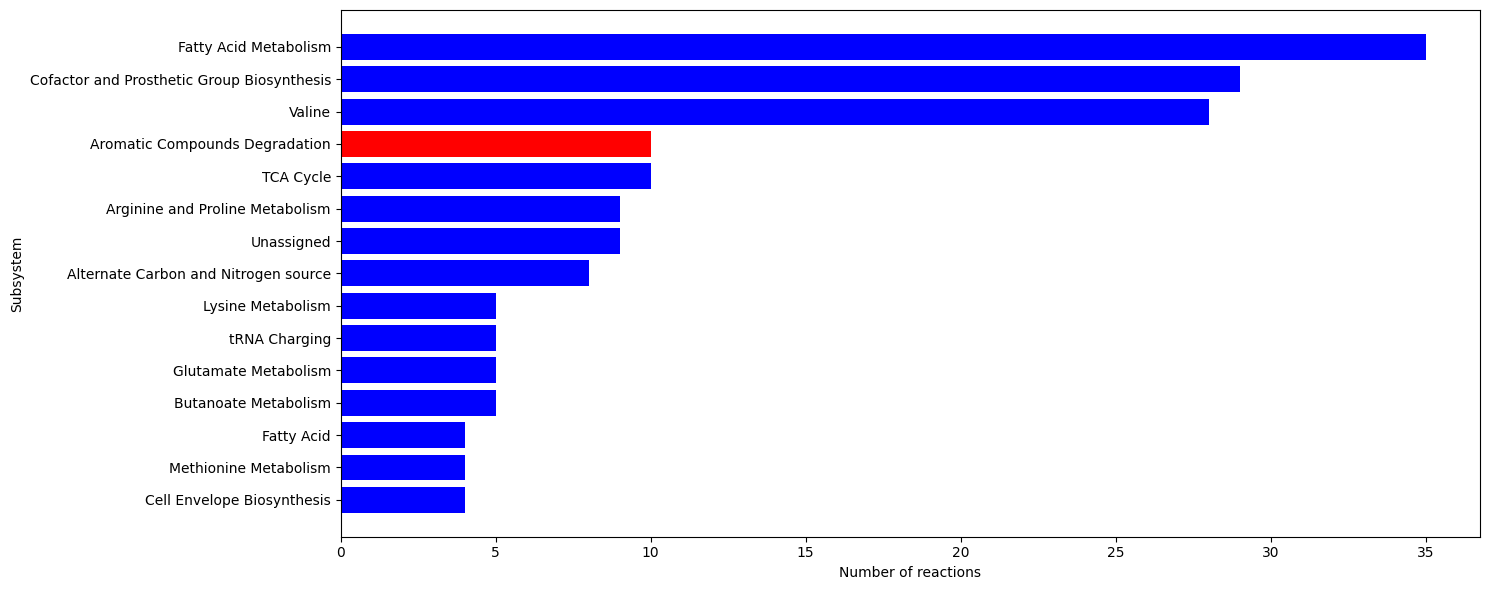

In [20]:
# Plot the results
import matplotlib.pyplot as plt

# Order
top_th = 15
top = subs_count.most_common(top_th)
labels, values = zip(*top)

# Colors
colors = [
    "red" if l in peri_enriched else "blue"
    for l in labels
]

# Plot
plt.figure(figsize=(15, 6))
plt.barh(labels[::-1], values[::-1], color=colors[::-1])
plt.xlabel("Number of reactions")
plt.ylabel("Subsystem")
plt.tight_layout()

plt.savefig("subsystems_extended.svg", bbox_inches="tight")

plt.show()

__Enrichment analysis in each subset__

In [21]:
# Extract no susceptible dataset
no_susceptible_table = ros_table[~ros_table["UniProt ID"].isin(susceptible_table["UniProt ID"])]
no_susceptible_table.shape

(864, 20)

In [22]:
# Store the subsystem for each reaction in susceptible data and no susceptible data separatedly
susceptible_subsystems = []
no_susceptible_subsystems = []

susceptible_ids = susceptible_table["KEGG ID"].tolist()
no_susceptible_ids = no_susceptible_table["KEGG ID"].tolist()

for rxn_name, gpr in reactions_gpr.items():

    # Reaction is susceptible
    if rxn_name in to_knock:
        rxn_subsystems = []
        for ID in gpr:
            ss = extract_subsystems(susceptible_table, ID)
            rxn_subsystems.extend(ss)
        
        rxn_subsystems = list(set(rxn_subsystems))
        susceptible_subsystems.extend(rxn_subsystems)

    # Reaction is not susceptible (contains at least 1 no susceptible enzyme)
    else:
        rxn_subsystems = []
        for ID in gpr:
            try:
                ss = extract_subsystems(no_susceptible_table, ID)
            except:
                ss = []  # ID is 
            rxn_subsystems.extend(ss)
        
        rxn_subsystems = list(set(rxn_subsystems))
        no_susceptible_subsystems.extend(rxn_subsystems)


In [23]:
susc_subsystem_count = Counter(susceptible_subsystems)
no_susc_subsystem_count = Counter(no_susceptible_subsystems)

all_subsystems = susceptible_subsystems + no_susceptible_subsystems
all_subsystems = set(all_subsystems)

print(len(all_subsystems))

47


In [24]:
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests

enrich_analysis_results = []

b = len(susceptible_subsystems)
d = len(no_susceptible_subsystems)

for subsystem in all_subsystems:

    try:
        a = susc_subsystem_count[subsystem]
        c = no_susc_subsystem_count[subsystem]
    
    except:
        continue


    cont_table = np.array([[a, b],[c,d]])  # Contingency table

    oddsratio, pvalue = fisher_exact(cont_table, alternative = "greater")

    subsystem_name = subsystem.replace('S_', '').replace('_', ' ')

    enrich_analysis_results.append({
            "subsystem": subsystem_name,
            "evidenced": a,
            "no_evidenced": c,
            "oddsratio": oddsratio,
            "pvalue": pvalue
        })


In [25]:
enrich_df = pd.DataFrame(enrich_analysis_results)
enrich_df.head()

,subsystem,evidenced,no_evidenced,oddsratio,pvalue
0,Lysine Metabolism,5,53,1.143469,0.459061
1,Pyrimidine Metabolism,3,81,0.448918,0.958190
2,Alanine and Aspartate Metabolism,1,17,0.712987,0.760439
3,Cysteine Metabolism,3,5,7.272464,0.018919
4,Xenobiotic tolerance,0,7,0.000000,1.000000


In [26]:
# Benjamini–Hochberg (FDR) correction
enrich_df = pd.DataFrame(enrich_analysis_results)
enrich_df["p_adj"] = multipletests(
    enrich_df["pvalue"],
    method = "fdr_bh"
)[1]

enrich_df.head()

,subsystem,evidenced,no_evidenced,oddsratio,pvalue,p_adj
0,Lysine Metabolism,5,53,1.143469,0.459061,1.000000
1,Pyrimidine Metabolism,3,81,0.448918,0.958190,1.000000
2,Alanine and Aspartate Metabolism,1,17,0.712987,0.760439,1.000000
3,Cysteine Metabolism,3,5,7.272464,0.018919,0.075975
4,Xenobiotic tolerance,0,7,0.000000,1.000000,1.000000


In [27]:
# Print only significant values
significant = enrich_df[enrich_df["p_adj"] <= 0.05]
significant

,subsystem,evidenced,no_evidenced,oddsratio,pvalue,p_adj
13,Unassigned,9,33,3.305665,4.256391e-03,0.033342
24,Biomass and maintenance functions,3,0,inf,4.546536e-04,0.005342
35,Valine,28,149,2.277729,3.337071e-04,0.005342
39,Nitrogen Metabolism,3,0,inf,4.546536e-04,0.005342
40,Arginine and Proline Metabolism,9,29,3.761619,2.070895e-03,0.019466
44,TCA Cycle,10,10,12.120773,7.337842e-07,0.000034
